<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_8/8_1_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1000)
np.random.seed(1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Перетворення: [0,1] -> [-1,1] і flatten 28*28 = 784
transform = transforms.Compose([
    transforms.ToTensor(),                    # [0,1]
    transforms.Lambda(lambda x: x.view(-1)),  # 784
    transforms.Lambda(lambda x: (x - 0.5) * 2)  # [-1,1]
])


In [3]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

print("train samples:", len(train_dataset))
print("input dim:", train_dataset[0][0].shape[0])  # 784

train samples: 60000
input dim: 784


In [4]:
input_dim = 784     # 28*28
latent_dim = 100    # розмір шуму

# Дискримінатор: 784 -> 1
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()      # дає ймовірність "справжнє"
        )

    def forward(self, x):
        return self.model(x)


In [5]:
# Генератор: 100 -> 784
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, input_dim),
            nn.Tanh()         # вихід у [-1,1], як дані
        )

    def forward(self, z):
        return self.model(z)


In [6]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# betas = (0.5, 0.999) — це класичний стандарт для DCGAN і MLP-GAN, рекомендований
# у оригінальному DCGAN paper (Radford et al., 2015) та використаний у більшості туторіалів.

In [7]:
#Функція для візуалізації згенерованих цифр
def plot_generated_images(epoch, generator, num_images=10):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, device=device)
        fake_images = generator(noise)  # [N, 784]
        fake_images = fake_images.view(-1, 28, 28).cpu().numpy()

    plt.figure(figsize=(10, 1))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # повертаємо з [-1,1] у [0,1] для відображення
        img = (fake_images[i] + 1) / 2
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Epoch: {epoch}")
    plt.tight_layout()
    plt.show()

    generator.train()


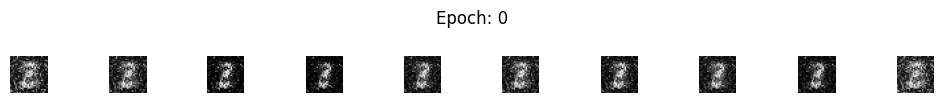

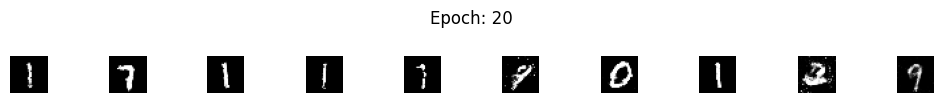

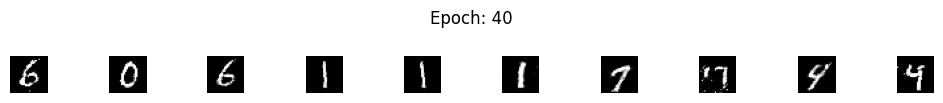

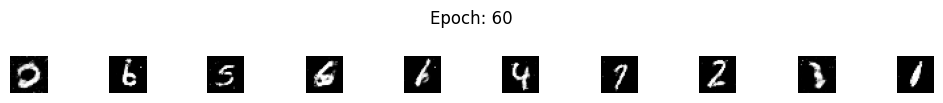

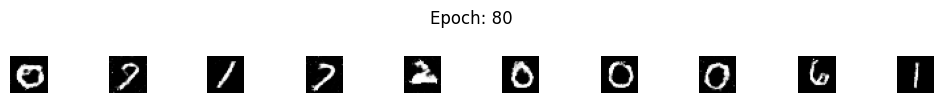

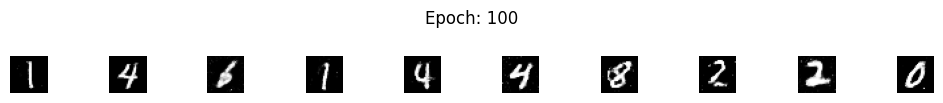

In [8]:
#Цикл навчання
discrim_losses = []

def train_gan(num_epochs):
    for epoch in range(num_epochs + 1):
        for real_images, _ in train_loader:
            real_images = real_images.to(device)  # [batch_size, 784]

            batch_size_curr = real_images.size(0)

            # --- Train Discriminator ---
            # Справжні мітки (з label smoothing: 0.9 замість 1.0)
            real_labels = torch.full((batch_size_curr, 1), 0.9, device=device)
            fake_labels = torch.zeros(batch_size_curr, 1, device=device)

            # Передбачення для реальних зображень
            outputs_real = discriminator(real_images)
            d_loss_real = criterion(outputs_real, real_labels)

            # Шум -> фейкові картинки
            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_images = generator(noise)

            outputs_fake = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            discrim_losses.append(d_loss.item())

            # --- Train Generator ---
            # Хочемо "обдурити" дискримінатор => мітки як для справжніх
            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images)

            g_loss = criterion(outputs, real_labels)  # хочемо 1

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        # Кожні 20 епох малюємо приклади
        if epoch % 20 == 0:
            plot_generated_images(epoch, generator)


num_epochs = 100
train_gan(num_epochs)

